In [ ]:
%%capture
!sudo apt update
!sudo apt install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
!pip install https://github.com/OlivierBeq/Papyrus-scripts/tarball/master
!pip install rdkit-pypi

In [ ]:
!papyrus download -s both -S -d none -V all

Number of files to be donwloaded: 9
Total size: 2.39GB
Donwloading version 05.4: 100% 2.39G/2.39G [00:31<00:00, 76.4MB/s]
Number of files to be donwloaded: 9
Total size: 2.30GB
Donwloading version 05.5: 100% 2.30G/2.30G [00:31<00:00, 72.1MB/s]


In [ ]:
import os

import pystow
import matplotlib.cm as cm
from matplotlib.ticker import *
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole 

from papyrus_scripts.reader import *
from papyrus_scripts.utils.IO import *
from papyrus_scripts.utils.mol_reader import MolSupplier

In [ ]:
sns.set(font_scale=2.5, rc={'text.usetex': True, "xtick.bottom" : True, "ytick.left" : True}, style='whitegrid')

In [ ]:
VERSION = '05.5'

In [ ]:
struct_path = pystow.join('papyrus', VERSION, 'structures')
bioact_path = pystow.join('papyrus', VERSION)

In [ ]:
sd_file = locate_file(struct_path, f'{VERSION}*_with_*.sd.xz')[0]
tsv_file = locate_file(bioact_path, f'{VERSION}*_without_*.tsv.xz')[0]

In [ ]:
npr = []
with MolSupplier(sd_file) as supplier:
    for i, mol in tqdm(supplier, total=get_num_rows_in_file('structures', True, version=VERSION)):
        connectivity = mol.GetProp('InChIKey').split('-')[0]
        npr.append((connectivity, rdMolDescriptors.CalcNPR1(mol), rdMolDescriptors.CalcNPR2(mol)))
npr = pd.DataFrame.from_records(npr, columns=['connectivity', 'NPR1', 'NPR2'])

  0%|          | 0/1402169 [00:00<?, ?it/s]

In [ ]:
sources = pd.concat([chunk for chunk in tqdm(pd.read_csv(tsv_file, sep='\t', usecols=['connectivity', 'source'], chunksize=1000000),
                                             total=int(round(get_num_rows_in_file('bioactivities', False, version=VERSION) / 1000000)))])
ChEMBL_connectivities = sources[sources.source.str.contains('ChEMBL')].connectivity.unique()
ExCAPE_connectivities = sources[sources.source.str.contains('ExCAPE-DB')].connectivity.unique()
Sharma_connectivities = sources[sources.source.str.contains('Sharma2016')].connectivity.unique()
Klaeger_connectivities = sources[sources.source.str.contains('Klaeger2017')].connectivity.unique()
Merget_connectivities = sources[sources.source.str.contains('Merget2017')].connectivity.unique()
Christmann_connectivities = sources[sources.source.str.contains('Christmann2016')].connectivity.unique()
ChEMBL_indices = npr[npr.connectivity.isin(ChEMBL_connectivities)].index.values
ExCAPE_indices = npr[npr.connectivity.isin(ExCAPE_connectivities)].index.values
Sharma_indices = npr[npr.connectivity.isin(Sharma_connectivities)].index.values
Klaeger_indices = npr[npr.connectivity.isin(Klaeger_connectivities)].index.values
Merget_indices = npr[npr.connectivity.isin(Merget_connectivities)].index.values
Christmann_indices = npr[npr.connectivity.isin(Christmann_connectivities)].index.values

In [ ]:
def mask_outside_polygon(poly_verts, ax=None, xlim=None, ylim=None, zorder=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # Set zorder for the white patch, lower zorder values are drawn first
    if zorder is None:
        zorder = 3000

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none', zorder=zorder)
    patch = ax.add_patch(patch)

    # # Reset the plot limits to their original extents
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)

    return patch

CPU times: user 32min 3s, sys: 19.2 s, total: 32min 22s
Wall time: 32min 15s


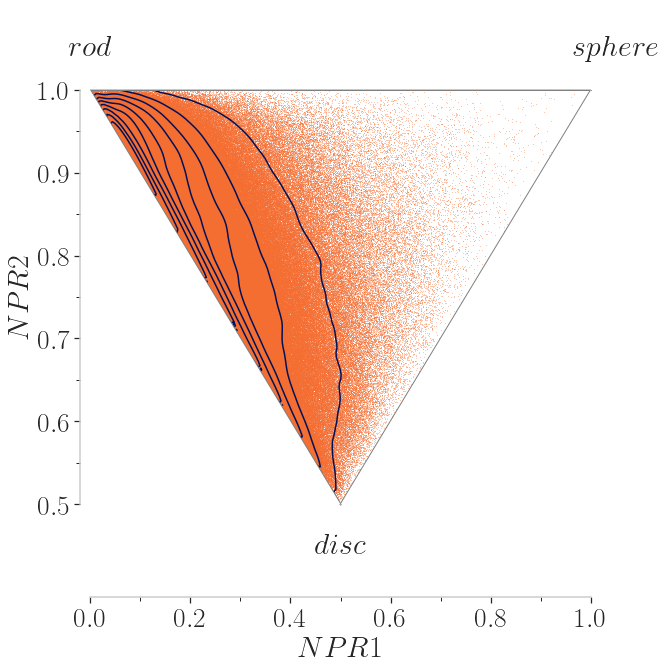

In [ ]:
%%time
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(10, 10))

ax1 = sns.scatterplot(x='NPR1', y='NPR2', data=npr, s=1, linewidth=0, alpha=0.5, color='#f46e32')
sns.kdeplot(x='NPR1', y='NPR2', data=npr, fill=False, levels=10, color='#001158', ax=ax)
x1, y1 = [0.5, 0], [0.5, 1]
x2, y2 = [0.5, 1], [0.5, 1]
x3, y3 = [0,1],[1,1]


poly_verts = [(0.0, 1.0), (0.5, 0.5), (1.0, 1.0), (0.0, 1.0)]
mask_outside_polygon(poly_verts, xlim=(-0.5, 1.5), ylim=(0.5, 1.5))
ax.set_xlim((0, 1))
ax.set_ylim((0.5, 1))

plt.plot(x1, y1, x2, y2, x3, y3, c='gray', ls='-', lw=2)
ax.grid(False)
ax.set_ylim(0.4, 1.1)
_ = ax.set_ylabel('$NPR2$')
_ = ax.set_xlabel('$NPR1$')
ax.yaxis.set_major_locator(FixedLocator([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
ax.yaxis.set_minor_locator(FixedLocator([x / 100 for x in range(55, 101, 10)]))
ax.xaxis.set_major_locator(FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
ax.xaxis.set_minor_locator(FixedLocator([x / 10 for x in range(11)]))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, trim=True);

plt.text(0, 1.05, s='$rod$', horizontalalignment='center', verticalalignment='center', zorder=3000)
plt.text(1.05, 1.05, s='$sphere$', horizontalalignment='center', verticalalignment='center', zorder=3000)
plt.text(0.5, 0.45, s='$disc$', horizontalalignment='center', verticalalignment='center', zorder=3000)

plt.tick_params('both', bottom=True, left=True)
plt.tight_layout()

fig.savefig('Papyrus_05.5_NPR_all_points.svg')
fig.show()

In [ ]:
from google.colab import files
files.download('Papyrus_05.5_NPR_all_points.svg') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 31min 45s, sys: 2min 4s, total: 33min 50s
Wall time: 33min 49s


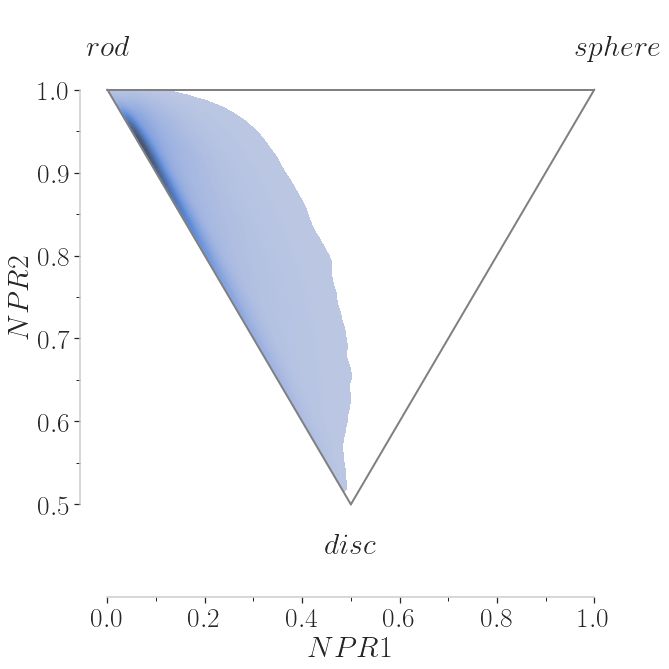

In [ ]:
%%time
plt.rcParams['axes.linewidth'] = 1.5
fig = plt.figure(figsize=(10, 10))

ax = sns.kdeplot(x='NPR1', y='NPR2', data=npr, fill=True, levels=100) #s=10, linewidth=0.5, alpha=0.75)
x1, y1 = [0.5, 0], [0.5, 1]
x2, y2 = [0.5, 1], [0.5, 1]
x3, y3 = [0,1],[1,1]


poly_verts = [(0.0, 1.0), (0.5, 0.5), (1.0, 1.0), (0.0, 1.0)]
mask_outside_polygon(poly_verts)

plt.plot(x1, y1, x2, y2, x3, y3, c='gray', ls='-', lw=2)
ax.grid(False)
ax.set_ylim(0.4, 1.1)
_ = ax.set_ylabel('$NPR2$')
_ = ax.set_xlabel('$NPR1$')
ax.yaxis.set_major_locator(FixedLocator([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
ax.yaxis.set_minor_locator(FixedLocator([x / 100 for x in range(55, 101, 10)]))
ax.xaxis.set_major_locator(FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
ax.xaxis.set_minor_locator(FixedLocator([x / 10 for x in range(11)]))

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
sns.despine(offset=10, trim=True);

plt.text(0, 1.05, s='$rod$', horizontalalignment='center', verticalalignment='center')
plt.text(1.05, 1.05, s='$sphere$', horizontalalignment='center', verticalalignment='center')
plt.text(0.5, 0.45, s='$disc$', horizontalalignment='center', verticalalignment='center')

plt.tick_params('both', bottom=True, left=True)
plt.tight_layout()

fig.savefig('Papyrus_05.5_NPR.svg')
fig.show()

In [ ]:
def get_subset_npr_plots(npr, indices, outfile):
    plt.rcParams['axes.linewidth'] = 1.5
    fig, ax = plt.subplots(figsize=(10, 10))

    ax1 = sns.scatterplot(x='NPR1', y='NPR2', data=npr, s=1, linewidth=0, alpha=0.5, color='#f46e32')
    sns.kdeplot(x='NPR1', y='NPR2', data=npr, fill=False, levels=20, color='#001158', ax=ax)
    # ax = sns.kdeplot(x='NPR1', y='NPR2', data=npr.iloc[indices], fill=True, levels=100) #s=10, linewidth=0.5, alpha=0.75)
    x1, y1 = [0.5, 0], [0.5, 1]
    x2, y2 = [0.5, 1], [0.5, 1]
    x3, y3 = [0,1],[1,1]

    poly_verts = [(0.0, 1.0), (0.5, 0.5), (1.0, 1.0), (0.0, 1.0)]
    mask_outside_polygon(poly_verts, xlim=(-0.5, 1.5), ylim=(0.5, 1.5))
    ax.set_xlim((0, 1))

    plt.plot(x1, y1, x2, y2, x3, y3, c='gray', ls='-', lw=2)
    ax.grid(False)
    ax.set_ylim(0.4, 1.1)
    _ = ax.set_ylabel('$NPR2$')
    _ = ax.set_xlabel('$NPR1$')
    ax.yaxis.set_major_locator(FixedLocator([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
    ax.yaxis.set_minor_locator(FixedLocator([x / 100 for x in range(55, 101, 10)]))
    ax.xaxis.set_major_locator(FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.xaxis.set_minor_locator(FixedLocator([x / 10 for x in range(11)]))

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    sns.despine(offset=10, trim=True);

    plt.text(0, 1.05, s='$rod$', horizontalalignment='center', verticalalignment='center', zorder=3000)
    plt.text(1.05, 1.05, s='$sphere$', horizontalalignment='center', verticalalignment='center', zorder=3000)
    plt.text(0.5, 0.45, s='$disc$', horizontalalignment='center', verticalalignment='center', zorder=3000)

    plt.tick_params('both', bottom=True, left=True)
    plt.tight_layout()

    fig.savefig(outfile)
    fig.show()
    from google.colab import files
    files.download(outfile) 

CPU times: user 47min 14s, sys: 2min 21s, total: 49min 35s
Wall time: 49min 25s


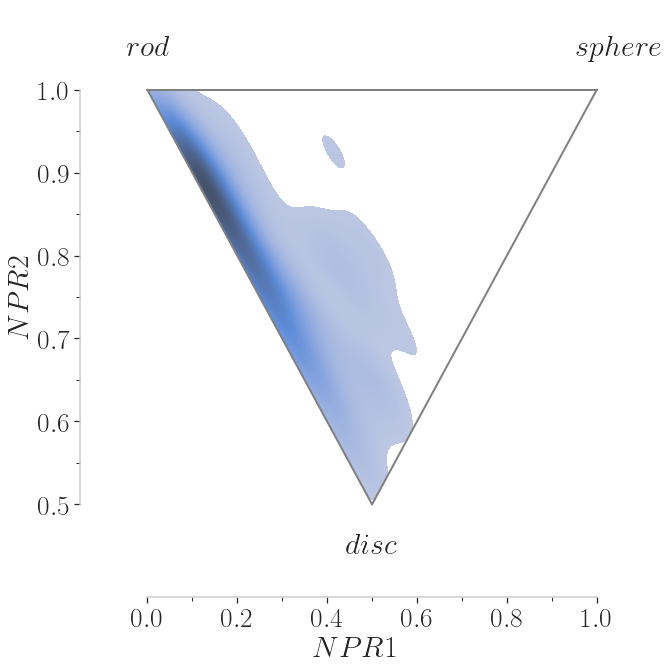

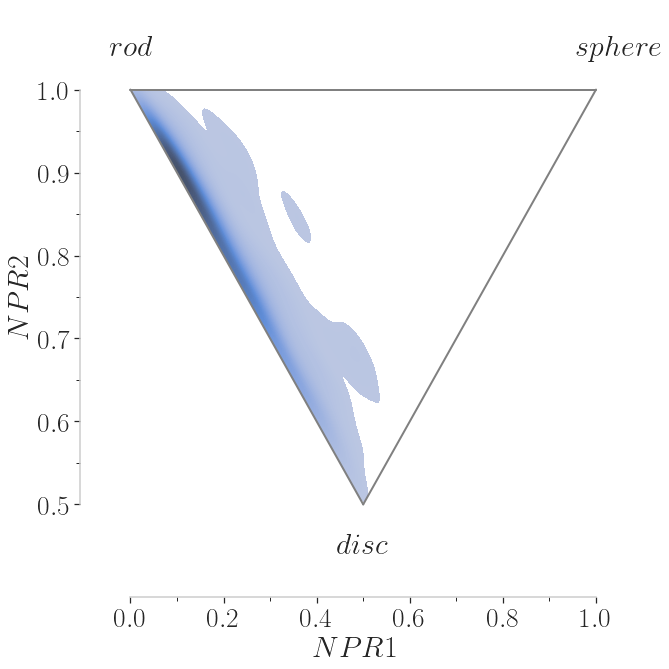

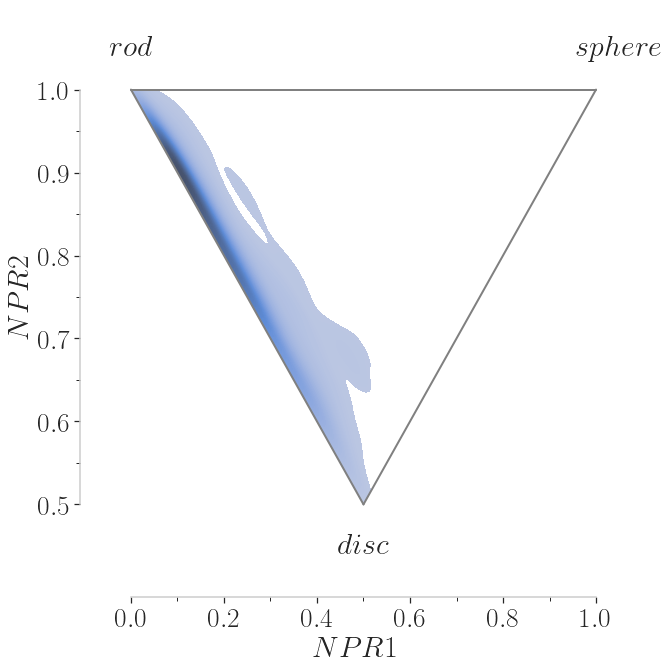

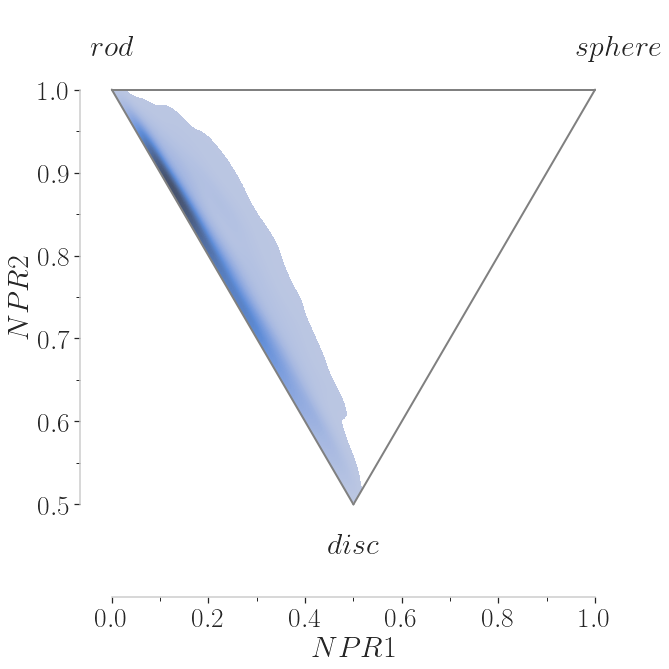

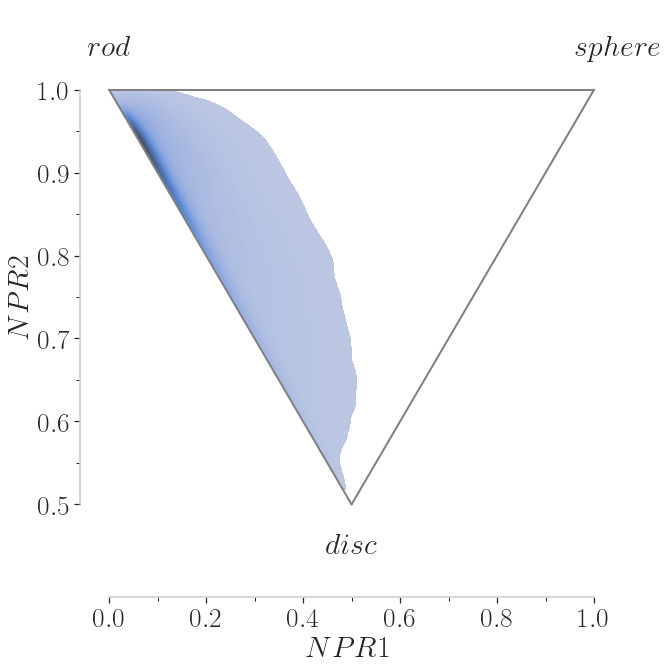

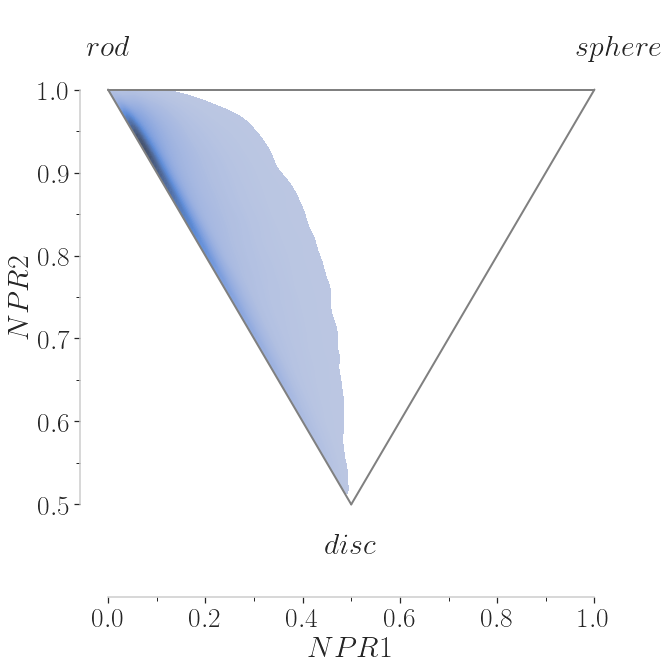

In [ ]:
%%time
get_subset_npr_plots(npr, Klaeger_indices, 'Papyrus_05.5_Klaeger_NPR_all_points.svg')
get_subset_npr_plots(npr, Christmann_indices, 'Papyrus_05.5_Christmann_NPR_all_points.svg')
get_subset_npr_plots(npr, Merget_indices, 'Papyrus_05.5_Merget_NPR_all_points.svg')
get_subset_npr_plots(npr, Sharma_indices, 'Papyrus_05.5_Sharma_NPR_all_points.svg')
get_subset_npr_plots(npr, ExCAPE_indices, 'Papyrus_05.5_ExCAPE_NPR_all_points.svg')
get_subset_npr_plots(npr, ChEMBL_indices, 'Papyrus_05.5_ChEMBL_NPR_all_points.svg')